# Part 1 : What is ```class``` and how do I get it?



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import CubicSpline

Installing `classy` via pip has been enabled since v3, though is not 100% reliable yet (especially for Mac)

In [ ]:
!pip install -q classy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 45.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!git clone git@github.com:lesgourg/class_public.git
!cd class; make clean; make -j

Cloning into 'class_public'...
Host key verification failed.
fatal: Could not read from remote repository.

Please make sure you have the correct access rights
and the repository exists.
/bin/bash: line 0: cd: class: No such file or directory
make: *** No rule to make target 'clean'.  Stop.
make: *** No targets specified and no makefile found.  Stop.


This is how to get an instance of `classy` with which to compute

In [ ]:
import classy
cosmo = classy.Class()

# Intermission: Computing `sigma8` (σ<sub>8</sub>)

Set desired cosmological parameters (we want the power spectrum up to 1/Mpc)

In [ ]:
cosmo.set({'output':'mPk','P_k_max_1/Mpc':1})

True

Don't forget to call `.compute()` !

In [ ]:
cosmo.compute()

Now get σ<sub>8</sub>

In [ ]:
cosmo.sigma8()

0.8249437822572525

# Part 2: Inputs and outputs -- How to work with `class`?

Again, set cosmological parameters

In [ ]:
cosmo.set({'m_ncdm':0.06,'N_ur':2.0328,'N_ncdm':1})

True

Don't forget to call `.compute()` !

In [ ]:
cosmo.compute()

In [ ]:
cosmo.Neff()

3.045998221453432

Now we can get any cosmological quantity we want

In [ ]:
bg = cosmo.get_background()
print(bg.keys())

dict_keys(['z', 'proper time [Gyr]', 'conf. time [Mpc]', 'H [1/Mpc]', 'comov. dist.', 'ang.diam.dist.', 'lum. dist.', 'comov.snd.hrz.', '(.)rho_g', '(.)rho_b', '(.)rho_cdm', '(.)rho_ncdm[0]', '(.)p_ncdm[0]', '(.)rho_lambda', '(.)rho_ur', '(.)rho_crit', '(.)rho_tot', '(.)p_tot', '(.)p_tot_prime', 'gr.fac. D', 'gr.fac. f'])


Let us, for example, plot comoving energy densities

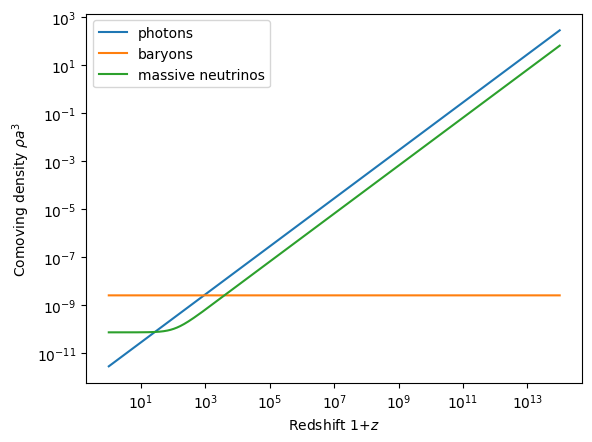

In [ ]:
opz = 1.+bg['z']
plt.loglog(opz,bg['(.)rho_g']/opz**3,label="photons")
plt.loglog(opz,bg['(.)rho_b']/opz**3,label="baryons")
plt.loglog(opz,bg['(.)rho_ncdm[0]']/opz**3,label="massive neutrinos")
plt.legend()
plt.xlabel(r"Redshift 1+$z$")
plt.ylabel(r"Comoving density $\rho a^3$")
plt.show()

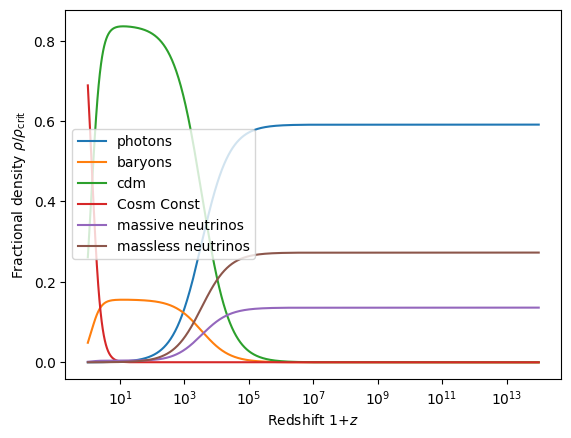

In [ ]:
opz = 1.+bg['z']
plt.semilogx(opz,bg['(.)rho_g']/bg['(.)rho_crit'],label="photons")
plt.semilogx(opz,bg['(.)rho_b']/bg['(.)rho_crit'],label="baryons")
plt.semilogx(opz,bg['(.)rho_cdm']/bg['(.)rho_crit'],label="cdm")
plt.semilogx(opz,bg['(.)rho_lambda']/bg['(.)rho_crit'],label="Cosm Const")
plt.semilogx(opz,bg['(.)rho_ncdm[0]']/bg['(.)rho_crit'],label="massive neutrinos")
plt.semilogx(opz,bg['(.)rho_ur']/bg['(.)rho_crit'],label="massless neutrinos")
plt.legend()
plt.xlabel(r"Redshift 1+$z$")
plt.ylabel(r"Fractional density $\rho/\rho_\mathrm{crit}$")
plt.show()

If we want to get power spectra as well, let's pass this as an input

In [ ]:
cosmo.set({'output':'tCl,lCl,pCl,mPk','lensing':'yes','non_linear':'halofit'})

True

In [ ]:
cosmo.compute()

In [ ]:
cl = cosmo.lensed_cl()

ks = np.geomspace(1e-5,1,num=1000)
pks = cosmo.get_pk_all(ks,z=0,nonlinear=False)
pks_nonlinear = cosmo.get_pk_all(ks,z=0,nonlinear=True)

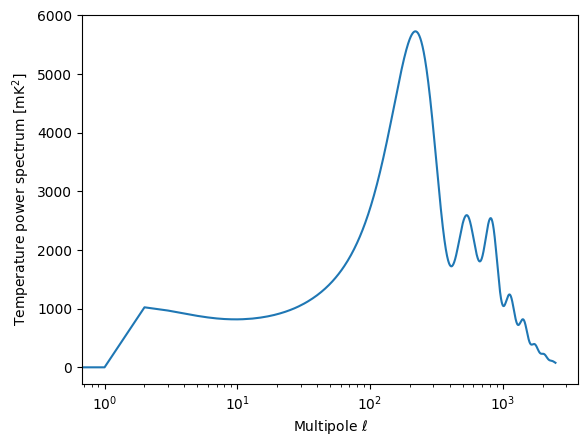

In [ ]:
plt.figure()
plt.semilogx(cl['ell'],cl['tt']*cl['ell']*(cl['ell']+1)*2.7255e6**2/(2.*np.pi))
plt.xlabel("Multipole $\ell$")
plt.ylabel("Temperature power spectrum [mK${}^2$]")
plt.show()

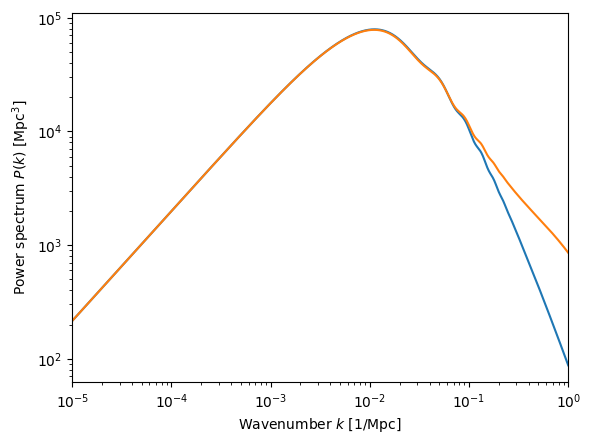

In [ ]:
plt.figure()
plt.loglog(ks,pks)
plt.loglog(ks,pks_nonlinear)
plt.xlabel("Wavenumber $k$ [1/Mpc]")
plt.ylabel("Power spectrum $P(k)$ [Mpc${}^3$]")
plt.xlim(1e-5,1)
plt.show()

# Part 3: The layout of `class` (internal and external)

Let's see some shooting!

In [ ]:
cosmo.empty()

theta_s_desired = 1.042

# First guess
h1 = 0.68
cosmo.set({'h':h1,'Omega_m':0.3})
cosmo.compute()
print("Guess 1:",cosmo.h())
guess1_theta_s = cosmo.theta_s_100()

# Second guess
h2 = 0.7
cosmo.set({'h':h2,'Omega_m':0.3})
cosmo.compute()
print("Guess 2:",cosmo.h())
guess2_theta_s = cosmo.theta_s_100()

print("Wanted: {}, gotten {} and {}".format(theta_s_desired,guess1_theta_s,guess2_theta_s))

# Compute next guess
dhdtheta = (h2-h1)/(guess2_theta_s-guess1_theta_s)
hnext = h1 + dhdtheta * (theta_s_desired - guess1_theta_s)
print("Guess3:",hnext)
cosmo.set({'h':hnext,'Omega_m':0.3})
cosmo.compute()
next_theta_s = cosmo.theta_s_100()
print("Wanted: {}, gotten {} (rel. err. {:.4f}%)".format(theta_s_desired,next_theta_s,100.*(next_theta_s/theta_s_desired-1)))

dhdtheta = (hnext-h2)/(next_theta_s-guess2_theta_s)
hnext = hnext + dhdtheta * (theta_s_desired - next_theta_s)
print("Guess4:",hnext)
cosmo.set({'h':hnext,'Omega_m':0.3})
cosmo.compute()
next_theta_s = cosmo.theta_s_100()
print("Wanted: {}, gotten {} (rel. err. {:.4f}%)".format(theta_s_desired,next_theta_s,100.*(next_theta_s/theta_s_desired-1)))

## Let's compare to what CLASS is doing

cosmo.empty()
cosmo.set({'100*theta_s':theta_s_desired,'Omega_m':0.3})
cosmo.compute()
print("CLASS h",cosmo.h())
class_theta_s = cosmo.theta_s_100()
print("Wanted: {}, CLASS result {} (rel. err. {:.4f}%)".format(theta_s_desired,class_theta_s,100.*(class_theta_s/theta_s_desired-1)))

Guess 1: 0.68
Guess 2: 0.7
Wanted: 1.042, gotten 1.037822383549007 and 1.0474455820919513
Guess3: 0.6886823864900015
Wanted: 1.042, gotten 1.042090772374143 (rel. err. 0.0087%)
Guess4: 0.6884905352941468
Wanted: 1.042, gotten 1.0419979877314969 (rel. err. -0.0002%)
CLASS h 0.6884925443046853
Wanted: 1.042, CLASS result 1.041998958656818 (rel. err. -0.0001%)


# Next steps: Model comparison



---


Let's now turn to comparing different models!

Example: 1-parameter extensions of ΛCDM!

In [ ]:
settings = {'output':'tCl,pCl,lCl,mPk','lensing':'yes','P_k_max_1/Mpc':12.}

default_params = {'omega_b':0.022, 'omega_cdm':0.12, 'h':0.68, 'A_s':2.1e-9, 'n_s':0.96 , 'Omega_k':0, 'N_ur':3.044}

varname = 'N_ur'#'omega_b'
varrange = np.linspace(3.044,3.144,num=3)#np.linspace(0.020, 0.024, num=5)

In [ ]:
ks_long = np.geomspace(1e-3,10,num=1000)

In [ ]:
M = {}
M['fid'] = classy.Class()
M['fid'].set(settings)
M['fid'].set(default_params)
M['fid'].compute()

for ivar,var in enumerate(varrange):
    M[ivar] = classy.Class()
    M[ivar].set(settings)
    M[ivar].set(default_params)
    M[ivar].set({varname:var})
    M[ivar].compute()

<ipython-input-20-4186342e5f3a>:10: RuntimeWarning: invalid value encountered in true_divide
  f1.gca().plot(cl['ell'],cl['tt']/clfid['tt']-1,color=color)


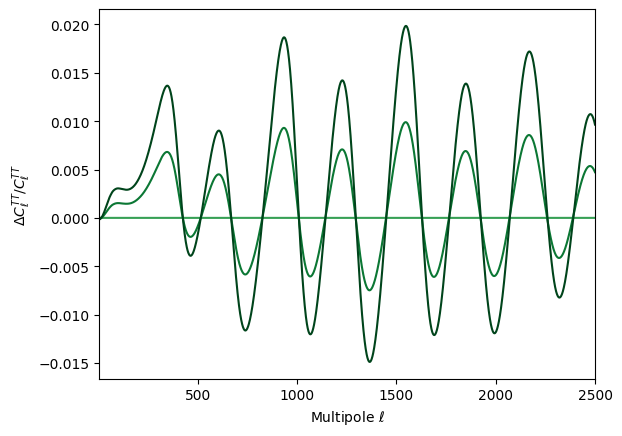

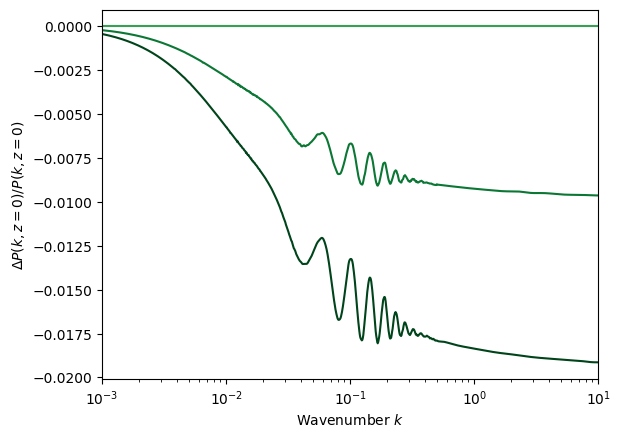

In [ ]:
f1 = plt.figure(1)
f2 = plt.figure(2)
clfid = M['fid'].lensed_cl()
pkfid = M['fid'].get_pk_all(ks_long,z=0)
for ivar,var in enumerate(varrange):
  cl = M[ivar].lensed_cl()

  color = plt.get_cmap("Greens")((ivar+1)*0.5/len(varrange)+0.5)

  f1.gca().plot(cl['ell'],cl['tt']/clfid['tt']-1,color=color)
  f1.gca().set_xlabel("Multipole $\ell$")
  f1.gca().set_ylabel("$\Delta C_\ell^{TT}/C^{TT}_\ell$")
  f1.gca().set_xlim(2,2500)
  f2.gca().semilogx(ks_long,M[ivar].get_pk_all(ks_long,z=0)/pkfid-1,color=color)
  f2.gca().set_xlabel("Wavenumber $k$")
  f2.gca().set_ylabel("$\Delta P(k,z=0)/P(k,z=0)$")
  f2.gca().set_xlim(1e-3,10)

plt.show()

Careful: Dependence on which parameters are fixed!